In [1]:
import sys
sys.path.insert(0, '../../')

In [14]:
import bd_calc
import graph
import importlib
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import topo
import typing
import utils
import yaml

matplotlib.rc('font', family='Times New Roman', size=18)

In [3]:
import all_cloud_cut
import best_cut
import flow_cut
import greedy_cut

def unit_size_cb(r: int):
    return 10000 * math.pow(10, random.randint(0, 1))

def cut_bd_compare(sc: topo.Scenario, graph_list: typing.List[graph.ExecutionGraph]):
    return (
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, all_cloud_cut.all_cloud_cut(sc, graph_list))),
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, flow_cut.flow_cut(sc, graph_list))),
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, greedy_cut.greedy_cut(sc, graph_list))),
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, greedy_cut.greedy_cut2(sc, graph_list))),
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, best_cut.best_cut(sc, graph_list))),
    )

def cut_bd_compare_no_best(sc: topo.Scenario, graph_list: typing.List[graph.ExecutionGraph]):
    return (
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, all_cloud_cut.all_cloud_cut(sc, graph_list))),
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, flow_cut.flow_cut(sc, graph_list))),
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, greedy_cut.greedy_cut(sc, graph_list))),
        sum(bd_calc.bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, greedy_cut.greedy_cut2(sc, graph_list))),
    )

In [4]:
from tqdm.notebook import trange

def run(topo_file, labels, source_selector_dict):
    sc = topo.Scenario.from_dict(
        yaml.load(open(topo_file, "r").read(), Loader=yaml.Loader)
    )
    test_round = 100
    base_data = np.zeros((len(labels), test_round))
    best_data = np.zeros((len(labels), test_round))
    flow_data = np.zeros((len(labels), test_round))
    greedy_data = np.zeros((len(labels), test_round))
    greedy2_data = np.zeros((len(labels), test_round))

    best_box_data = np.zeros((len(labels), test_round))
    flow_box_data = np.zeros((len(labels), test_round))
    greedy_box_data = np.zeros((len(labels), test_round))
    greedy2_box_data = np.zeros((len(labels), test_round))
    for idx, graph_count in enumerate(labels):
        for r in trange(test_round, desc="running with {} graphs".format(graph_count)):
            source_selector = graph.SourceSelector(source_selector_dict)
            gen_args_list = [
                    {
                    "total_rank": random.randint(3, 7),
                    "max_node_per_rank": random.randint(1, 2),
                    "max_predecessors": random.randint(1, 2),
                    "mi_cb": lambda: 1,
                    "memory_cb": lambda: int(2e8),
                    "unit_size_cb": unit_size_cb,
                    "unit_rate_cb": lambda: random.randint(10, 20),
                    "source_hosts": source_selector,
                    "sink_hosts": ["cloud1"],
                }
                for _ in range(graph_count)
            ]
            graph_list = [
                graph.GraphGenerator("g" + str(idx), **gen_args).gen_dag_graph()
                for idx, gen_args in enumerate(gen_args_list)
            ]
            base, flow, greedy, greedy2, best = cut_bd_compare(sc, graph_list)
            if flow > base:
                print('flow {}, base {}'.format(flow, base))
            if flow < best:
                print('flow {}, best {}'.format(flow, best))
            base_data[idx][r] = base
            best_data[idx][r] = best
            flow_data[idx][r] = flow
            greedy_data[idx][r] = greedy
            greedy2_data[idx][r] = greedy2
            flow_box_data[idx][r] = flow / base
            best_box_data[idx][r] = best / base
            greedy_box_data[idx][r] = greedy / base
            greedy2_box_data[idx][r] = greedy2 / base
    print('base', base_data.mean(axis=1) / 1e6)
    print('best', best_data.mean(axis=1) / 1e6)
    print('flow', flow_data.mean(axis=1) / 1e6)
    print('greedy', greedy_data.mean(axis=1) / 1e6)
    print('greedy2', greedy2_data.mean(axis=1) / 1e6)
    return best_box_data, flow_box_data, greedy_box_data, greedy2_box_data

In [5]:
def run_no_best(topo_file, labels, source_selector_dict):
    sc = topo.Scenario.from_dict(
        yaml.load(open(topo_file, "r").read(), Loader=yaml.Loader)
    )
    test_round = 100
    base_data = np.zeros((len(labels), test_round))
    flow_data = np.zeros((len(labels), test_round))
    greedy_data = np.zeros((len(labels), test_round))
    greedy2_data = np.zeros((len(labels), test_round))
    flow_box_data = np.zeros((len(labels), test_round))
    greedy_box_data = np.zeros((len(labels), test_round))
    greedy2_box_data = np.zeros((len(labels), test_round))

    for idx, graph_count in enumerate(labels):
        for r in trange(test_round, desc="running with {} graphs".format(graph_count)):
            source_selector = graph.SourceSelector(source_selector_dict)
            gen_args_list = [
                    {
                    "total_rank": random.randint(3, 7),
                    "max_node_per_rank": random.randint(1, 2),
                    "max_predecessors": random.randint(1, 2),
                    "mi_cb": lambda: 1,
                    "memory_cb": lambda: int(2e8),
                    "unit_size_cb": unit_size_cb,
                    "unit_rate_cb": lambda: random.randint(10, 20),
                    "source_hosts": source_selector,
                    "sink_hosts": ["cloud1"],
                }
                for _ in range(graph_count)
            ]
            graph_list = [
                graph.GraphGenerator("g" + str(idx), **gen_args).gen_dag_graph()
                for idx, gen_args in enumerate(gen_args_list)
            ]
            base, flow, greedy, greedy2 = cut_bd_compare_no_best(sc, graph_list)
            if flow > base:
                print('flow {}, base {}'.format(flow, base))
            base_data[idx][r] = base
            flow_data[idx][r] = flow
            greedy_data[idx][r] = greedy
            greedy2_data[idx][r] = greedy2
            flow_box_data[idx][r] = flow / base
            greedy_box_data[idx][r] = greedy / base
            greedy2_box_data[idx][r] = greedy2 / base
    print('base', base_data.mean(axis=1) / 1e6)
    print('flow', flow_data.mean(axis=1) / 1e6)
    print('greedy', greedy_data.mean(axis=1) / 1e6)
    print('greedy2', greedy2_data.mean(axis=1) / 1e6)
    return flow_box_data, greedy_box_data, greedy2_box_data

In [11]:
small_labels = [4, 8, 12, 16, 20]
source_dict = {'rasp1': 8, 'rasp2': 8, 'rasp3': 8}
small_best_box_data, small_flow_box_data, small_greedy_box_data, small_greedy2_box_data = run("../../samples/1e3h.yaml", small_labels, source_dict)

medium_labels = [40, 60, 80, 100, 120]
source_dict = {'rasp'+str(i): 8 for i in range(1, 7)}
source_dict.update({'vm'+str(i): 16 for i in range(1, 7)})
medium_flow_box_data, medium_greedy_box_data, medium_greedy2_box_data = run_no_best("../../samples/1e12h.yaml", medium_labels, source_dict)

large_labels = [200, 300, 400, 500, 600]
source_dict = {'e0rasp'+str(i): 8 for i in range(1, 9)}
source_dict.update({'e1rasp'+str(i): 8 for i in range(1, 9)})
source_dict.update({'e0vm'+str(i): 16 for i in range(1, 9)})
source_dict.update({'e1vm'+str(i): 16 for i in range(1, 9)})
source_dict.update({'e0desktop'+str(i): 32 for i in range(1, 5)})
source_dict.update({'e1desktop'+str(i): 32 for i in range(1, 5)})
large_flow_box_data, large_greedy_box_data, large_greedy2_box_data = run_no_best("../../samples/1e40h.yaml", large_labels, source_dict)

running with 4 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 8 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 12 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 16 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 20 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

base [ 7.6433 15.111  22.8015 29.5482 37.8858]
best [ 5.1393 10.3784 15.8062 21.6723 32.1053]
flow [ 5.1844 10.4453 16.1423 22.1545 32.5084]
greedy [ 9.5307 18.9204 27.3479 36.4881 43.8657]
greedy2 [ 9.0894 17.9333 26.0076 32.4268 39.8576]


running with 40 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 60 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 80 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 100 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 120 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

base [ 77.1086 113.1563 150.1164 187.1709 225.1026]
flow [ 52.6723  77.8253 104.7024 140.9699 191.2683]
greedy [ 92.7802 131.8111 184.8074 225.3607 261.969 ]
greedy2 [ 90.3028 134.8903 176.4584 204.3691 241.1095]


running with 200 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 300 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 400 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 500 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

running with 600 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

base [ 378.2291  561.3099  749.4046  944.5714 1130.0127]
flow [ 257.4928  385.733   532.8391  765.3714 1062.1923]
greedy [ 453.7293  670.6054  911.3048 1106.6484 1236.9395]
greedy2 [ 447.9826  667.445   825.6549 1009.7028 1186.0181]


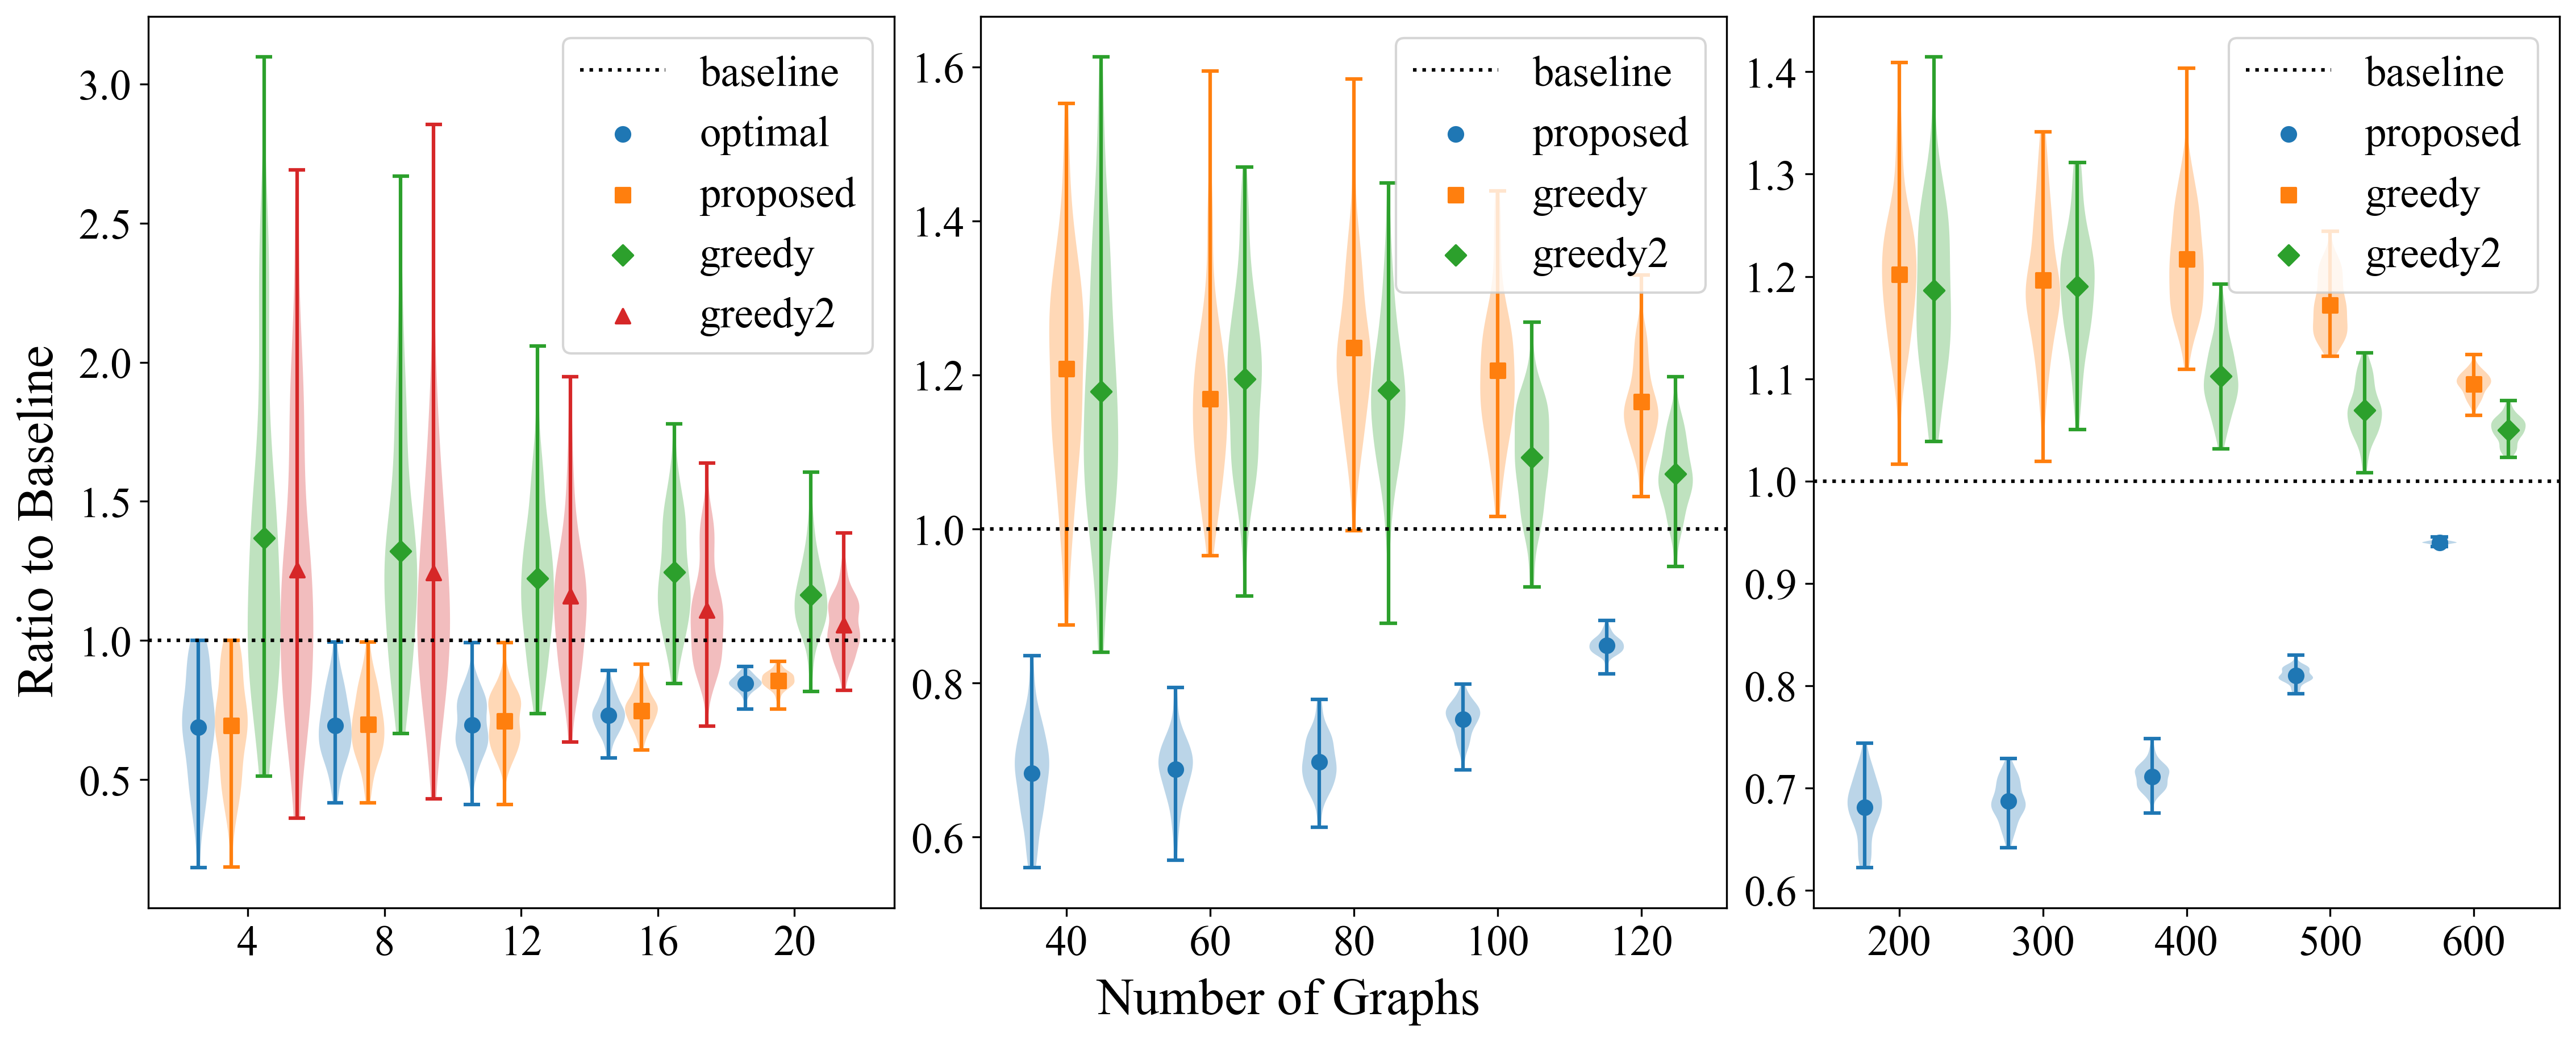

In [16]:
label_count = 5
def postprocess(data):
    return [data[i] for i in range(label_count)]

fig, axes = plt.subplots(1, 3, figsize=(15, 6), dpi=300, constrained_layout=True)
fig.supxlabel('Number of Graphs')
fig.supylabel('Ratio to Baseline')

ax = axes[0]
_ = ax.set_xticks([i+1 for i in range(label_count)])
_ = ax.set_xticklabels(small_labels)
width = 0.24
small_base_plot = ax.axhline(y=1, color='black', linestyle='dotted')
_ = ax.violinplot(postprocess(small_best_box_data), vert=True, positions=[i-width*3/2 for i in range(1, label_count+1)], widths=width)
_ = ax.violinplot(postprocess(small_flow_box_data), vert=True, positions=[i-width/2 for i in range(1, label_count+1)], widths=width)
_ = ax.violinplot(postprocess(small_greedy_box_data), vert=True, positions=[i+width/2 for i in range(1, label_count+1)], widths=width)
_ = ax.violinplot(postprocess(small_greedy2_box_data), vert=True, positions=[i+width*3/2 for i in range(1, label_count+1)], widths=width)
small_best_plot = ax.scatter([i-width*3/2 for i in range(1, label_count+1)], small_best_box_data.mean(axis=1), marker='o')
small_flow_plot = ax.scatter([i-width/2 for i in range(1, label_count+1)], small_flow_box_data.mean(axis=1), marker='s')
small_greedy_plot = ax.scatter([i+width/2 for i in range(1, label_count+1)], small_greedy_box_data.mean(axis=1), marker='D')
small_greedy2_plot = ax.scatter([i+width*3/2 for i in range(1, label_count+1)], small_greedy2_box_data.mean(axis=1), marker='^')
_ = ax.legend([small_base_plot, small_best_plot, small_flow_plot, small_greedy_plot, small_greedy2_plot], ['baseline', 'optimal', 'proposed', 'greedy', 'greedy2'], prop={'size': '18'})

ax = axes[1]
_ = ax.set_xticks([i+1 for i in range(label_count)])
_ = ax.set_xticklabels(medium_labels)
width = 0.24
medium_base_plot = ax.axhline(y=1, color='black', linestyle='dotted')
_ = ax.violinplot(postprocess(medium_flow_box_data), vert=True, positions=[i-width for i in range(1, label_count+1)], widths=width)
_ = ax.violinplot(postprocess(medium_greedy_box_data), vert=True, positions=[i for i in range(1, label_count+1)], widths=width)
_ = ax.violinplot(postprocess(medium_greedy2_box_data), vert=True, positions=[i+width for i in range(1, label_count+1)], widths=width)
medium_flow_plot = ax.scatter([i-width for i in range(1, label_count+1)], medium_flow_box_data.mean(axis=1), marker='o')
medium_greedy_plot = ax.scatter([i for i in range(1, label_count+1)], medium_greedy_box_data.mean(axis=1), marker='s')
medium_greedy2_plot = ax.scatter([i+width for i in range(1, label_count+1)], medium_greedy2_box_data.mean(axis=1), marker='D')
_ = ax.legend([medium_base_plot, medium_flow_plot, medium_greedy_plot, medium_greedy2_plot], ['baseline', 'proposed', 'greedy', 'greedy2'], prop={'size': '18'})

ax = axes[2]
_ = ax.set_xticks([i+1 for i in range(label_count)])
_ = ax.set_xticklabels(large_labels)
width = 0.24
large_base_plot = ax.axhline(y=1, color='black', linestyle='dotted')
_ = ax.violinplot(postprocess(large_flow_box_data), vert=True, positions=[i-width for i in range(1, label_count+1)], widths=width)
_ = ax.violinplot(postprocess(large_greedy_box_data), vert=True, positions=[i for i in range(1, label_count+1)], widths=width)
_ = ax.violinplot(postprocess(large_greedy2_box_data), vert=True, positions=[i+width for i in range(1, label_count+1)], widths=width)
large_flow_plot = ax.scatter([i-width for i in range(1, label_count+1)], large_flow_box_data.mean(axis=1), marker='o')
large_greedy_plot = ax.scatter([i for i in range(1, label_count+1)], large_greedy_box_data.mean(axis=1), marker='s')
large_greedy2_plot = ax.scatter([i+width for i in range(1, label_count+1)], large_greedy2_box_data.mean(axis=1), marker='D')
_ = ax.legend([large_base_plot, large_flow_plot, large_greedy_plot, large_greedy2_plot], ['baseline', 'proposed', 'greedy', 'greedy2'], prop={'size': '18'})

fig.show()

In [8]:
def debug(topo_file, source_selector_dict):
    sc = topo.Scenario.from_dict(
        yaml.load(open(topo_file, "r").read(), Loader=yaml.Loader)
    )
    while True:
        source_selector = graph.SourceSelector(source_selector_dict)
        gen_args ={
                "total_rank": random.randint(3, 7),
                "max_node_per_rank": random.randint(1, 2),
                "max_predecessors": random.randint(1, 2),
                "mi_cb": lambda: 1,
                "memory_cb": lambda: int(2e8),
                "unit_size_cb": unit_size_cb,
                "unit_rate_cb": lambda: random.randint(10, 20),
                "source_hosts": source_selector,
                "sink_hosts": ["cloud1"],
            }
        g = graph.GraphGenerator("g-debug", **gen_args).gen_dag_graph()
        flow_result = flow_cut.flow_cut(sc, [g])[0]
        flow_bd = bd_calc.bd_calc(g, flow_result[0], flow_result[1])
        best_result = best_cut.best_cut(sc, [g])[0]
        best_bd = bd_calc.bd_calc(g, best_result[0], best_result[1])
        if flow_bd < best_bd:
            for u, v, _ in g.get_edges():
                print('{} ---> {}'.format(u, v))
            print(flow_bd)
            print(best_bd)
            print(flow_result)
            print(best_result)
            break